In [98]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [127]:
%load_ext lab_black

In [107]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
import pandas as pd
import lightgbm

import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

from hm_fashion.model import get_ranker_pipeline

In [101]:
pd.options.display.float_format = "{:.2f}".format

## Load Training Data

In [261]:
%%bigquery training_data_size --project zenscr-seefood-dev

SELECT 
    obs_dat,
    COUNT(DISTINCT customer_id) AS num_customers,
    COUNT(DISTINCT article_id) AS num_articles,
    COUNT(*) AS num_rows
FROM hm_kaggle_reco.training_data_sample t
GROUP BY obs_dat

Q
D


In [262]:
training_data_size

,obs_dat,num_customers,num_articles,num_rows
0,2020-04-01,1482,7437,9727584
1,2020-04-08,1591,4694,4225650


In [263]:
%%bigquery training_data --project zenscr-seefood-dev

SELECT 
    t.obs_dat,
    t.customer_id,
    article_id,
    score,
    relevance,
    feat_price_affinity,
    feat_dark_affinity,
    feat_dusty_light_affinity
FROM hm_kaggle_reco.training_data_sample t
LEFT JOIN hm_kaggle_reco.feat_customer fc
       ON t.obs_dat = fc.obs_dat AND t.customer_id = fc.customer_id
ORDER BY customer_id, relevance DESC

Q
D


In [264]:
with pd.option_context("display.max_colwidth", -1):
    display(training_data)

,obs_dat,customer_id,article_id,score,relevance,feat_price_affinity,feat_dark_affinity,feat_dusty_light_affinity
0,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f994d47a77dba1ac66b,887911002,123.00,1,NaN,NaN,NaN
1,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f994d47a77dba1ac66b,830360001,-1.00,1,NaN,NaN,NaN
2,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f994d47a77dba1ac66b,887949002,-1.00,1,NaN,NaN,NaN
3,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f994d47a77dba1ac66b,703761009,-1.00,1,NaN,NaN,NaN
4,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f994d47a77dba1ac66b,777018003,-1.00,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
13953229,2020-04-01,ffe997b92b39a1b292cb0eb43c9b89e3b650481dcb4ea09abdfc51026e11a084,750423005,44.00,0,NaN,NaN,NaN
13953230,2020-04-01,ffe997b92b39a1b292cb0eb43c9b89e3b650481dcb4ea09abdfc51026e11a084,708459006,54.00,0,NaN,NaN,NaN
13953231,2020-04-01,ffe997b92b39a1b292cb0eb43c9b89e3b650481dcb4ea09abdfc51026e11a084,663519001,55.00,0,NaN,NaN,NaN
13953232,2020-04-01,ffe997b92b39a1b292cb0eb43c9b89e3b650481dcb4ea09abdfc51026e11a084,799349001,102.00,0,NaN,NaN,NaN


In [265]:
training_data.isna().mean()

obs_dat                     0.00
customer_id                 0.00
article_id                  0.00
score                       0.00
relevance                   0.00
feat_price_affinity         0.14
feat_dark_affinity          0.14
feat_dusty_light_affinity   0.14
dtype: float64

In [266]:
training_data.to_parquet("training_data.parquet")

## Explore Training Data

In [267]:
training_data["relevance"].value_counts()

0    13939793
1       13441
Name: relevance, dtype: Int64

In [268]:
training_data["score"].describe()

count   13953234.00
mean         162.22
std          187.33
min           -1.00
25%           51.00
50%          106.00
75%          192.00
max         2656.00
Name: score, dtype: float64

<AxesSubplot:ylabel='Frequency'>

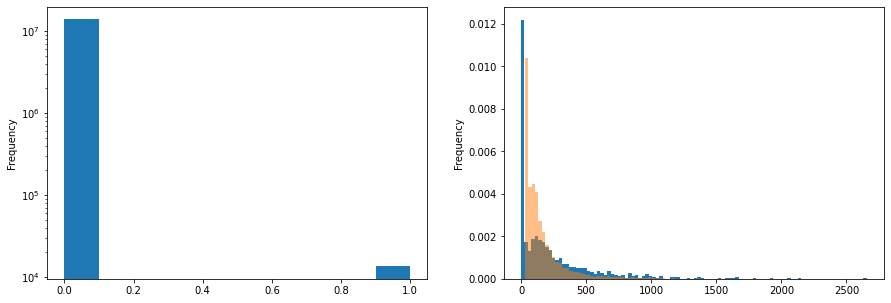

In [269]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

training_data["relevance"].plot.hist(log=True, ax=axs[0])

training_data[lambda d: d["relevance"] == 1]["score"].plot.hist(
    density=True, bins=100, ax=axs[1]
)
training_data[lambda d: d["relevance"] == 0]["score"].plot.hist(
    density=True, alpha=0.5, bins=100, ax=axs[1]
)

In [270]:
training_data.shape

(13953234, 8)

In [271]:
training_data[lambda d: d["relevance"] == 1]["score"].map(
    lambda r: 1 if r == -1 else 0
).value_counts()

0    9087
1    4354
Name: score, dtype: int64

## Model Training

In [272]:
pipe = get_ranker_pipeline()

In [273]:
model = pipe[-1]

In [274]:
pipe

Pipeline(steps=[('features',
                 Pipeline(steps=[('to_dataframe',
                                  FunctionTransformer(func=<function to_dataframe at 0x13cccbb80>,
                                                      kw_args={'col_labels': ['score',
                                                                              'feat_price_affinity',
                                                                              'feat_dark_affinity',
                                                                              'feat_dusty_light_affinity']}))])),
                ('ranker', LGBMRanker(metric='ndcg', objective='lambdarank'))])

In [275]:
training_data.head(5)

,obs_dat,customer_id,article_id,score,relevance,feat_price_affinity,feat_dark_affinity,feat_dusty_light_affinity
0,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f...,887911002,123.00,1,NaN,NaN,NaN
1,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f...,830360001,-1.00,1,NaN,NaN,NaN
2,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f...,887949002,-1.00,1,NaN,NaN,NaN
3,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f...,703761009,-1.00,1,NaN,NaN,NaN
4,2020-04-08,001dcccfc98e5305bd3759ebef9f7a027c9c09933acd8f...,777018003,-1.00,1,NaN,NaN,NaN


In [276]:
training_data.dtypes

obs_dat                       dbdate
customer_id                   object
article_id                     Int64
score                        float64
relevance                      Int64
feat_price_affinity          float64
feat_dark_affinity           float64
feat_dusty_light_affinity    float64
dtype: object

In [278]:
dates = training_data["obs_dat"].unique()
dates

<DateArray>
[datetime.date(2020, 4, 8), datetime.date(2020, 4, 1)]
Length: 2, dtype: dbdate

In [279]:
df_train = (
    training_data[lambda d: (d["score"] >= 0) & (d["obs_dat"] == dates[1])]
    .groupby("customer_id")
    .apply(lambda g: g.sample(frac=1))
    .reset_index(drop=True)
)
X_train = pipe[:-1].fit_transform(df_train)
y_train = df_train["relevance"].astype("int32")
qids_train = df_train.groupby("customer_id")["customer_id"].count().to_numpy()

X_train.shape, len(y_train), len(qids_train)

((9726366, 4), 9726366, 1482)

In [280]:
df_val = (
    training_data[lambda d: (d["score"] >= 0) & (d["obs_dat"] == dates[0])]
    .groupby("customer_id")
    .apply(lambda g: g.sample(frac=1))
    .reset_index(drop=True)
)
X_val = pipe[:-1].fit_transform(df_val)
y_val = df_val["relevance"].astype("int32")
qids_val = df_val.groupby("customer_id")["customer_id"].count().to_numpy()

X_val.shape, len(y_val), len(qids_val)

((4222514, 4), 4222514, 1591)

In [281]:
df_train["relevance"].value_counts()

0    9721494
1       4872
Name: relevance, dtype: Int64

In [284]:
model.fit(
    X=X_train,
    y=y_train,
    group=qids_train,
    eval_set=[(X_val, y_val)],
    eval_group=[qids_val],
    eval_at=12,
    callbacks=[lightgbm.log_evaluation()],
)

[1]	valid_0's ndcg@5: 0.165363
[2]	valid_0's ndcg@5: 0.164244
[3]	valid_0's ndcg@5: 0.161354
[4]	valid_0's ndcg@5: 0.162723
[5]	valid_0's ndcg@5: 0.164847
[6]	valid_0's ndcg@5: 0.161571
[7]	valid_0's ndcg@5: 0.162667
[8]	valid_0's ndcg@5: 0.161916
[9]	valid_0's ndcg@5: 0.161337
[10]	valid_0's ndcg@5: 0.162199
[11]	valid_0's ndcg@5: 0.162017
[12]	valid_0's ndcg@5: 0.161607
[13]	valid_0's ndcg@5: 0.162789
[14]	valid_0's ndcg@5: 0.163293
[15]	valid_0's ndcg@5: 0.162391
[16]	valid_0's ndcg@5: 0.163744
[17]	valid_0's ndcg@5: 0.161909
[18]	valid_0's ndcg@5: 0.162955
[19]	valid_0's ndcg@5: 0.16317
[20]	valid_0's ndcg@5: 0.163177
[21]	valid_0's ndcg@5: 0.162804
[22]	valid_0's ndcg@5: 0.163261
[23]	valid_0's ndcg@5: 0.164184
[24]	valid_0's ndcg@5: 0.163338
[25]	valid_0's ndcg@5: 0.164181
[26]	valid_0's ndcg@5: 0.163944
[27]	valid_0's ndcg@5: 0.163722
[28]	valid_0's ndcg@5: 0.16385
[29]	valid_0's ndcg@5: 0.163707
[30]	valid_0's ndcg@5: 0.16333
[31]	valid_0's ndcg@5: 0.162677
[32]	valid_0's ndcg@

LGBMRanker(metric='ndcg', objective='lambdarank')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

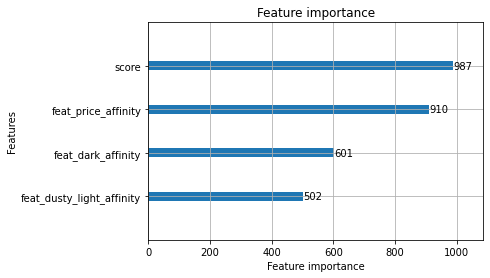

In [285]:
lightgbm.plot_importance(model)